In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures,scale
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, LinearRegression,Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer,IterativeImputer
from category_encoders.target_encoder import TargetEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [4]:
path1 = "/Users/racheltan/Desktop/QMSS/AML/winemag-data-130k-v2.csv"
path2 = "/Users/ellen/Documents/GitHub/assignment-4-rachel_ellen/wine-reviews/winemag-data-130k-v2.csv"

wine_raw = pd.read_csv(path2, index_col = 0).drop(['taster_name', 'taster_twitter_handle'], axis = 1)

#used the dataset with 130k rows
#dropped the title since it contains mostly unique values and would be equivalent to and id column leaking information 
#dropped taster twitter handle and taster name 

In [5]:
wine_usa = wine_raw[wine_raw.country == 'US']
wine_usa_skew = wine_usa[wine_usa.price < 250].drop_duplicates('description') #using wine only from US, remove duplicate rows and outliers

In [6]:
len(wine_usa)

54504

In [7]:
len(wine_usa_skew) #remove 300 rows of outliers

50170

In [31]:
wine_us = wine_usa_skew.sample(n = 20000, random_state = 123) #subsample 20k rows 

In [32]:
wine_us.isnull().sum()

country           0
description       0
designation    6418
points            0
price             0
province          0
region_1        115
region_2       1478
title             0
variety           0
winery            0
dtype: int64

In [33]:
wine_us.price.nlargest()

95049     240.0
10747     235.0
5025      230.0
66940     225.0
122558    225.0
Name: price, dtype: float64

# 1.1 Create a baseline model for predicting wine quality using only non-text features.


Target Feature: Points (indicating wine quality) 

Predictive Non-Text Features: 
- Designation 
- Price 
- Province 
- Region_1
- Region_2
- Variety
- Winery 

We treat price as continuous and the rest as high cardinality categorical variables

Text(0, 0.5, 'Frequency')

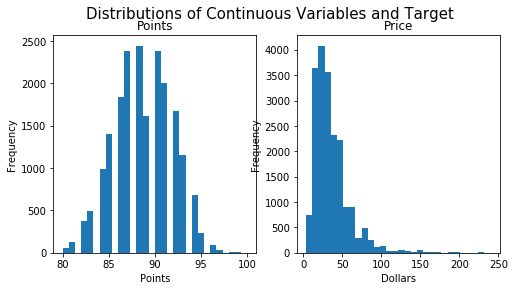

In [34]:
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
points, price = axes.ravel()
fig.suptitle('Distributions of Continuous Variables and Target', fontsize=15)
axes[0].hist('points', data = wine_us, bins = 30)
axes[0].set_title('Points')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Frequency')

axes[1].hist('price', data = wine_us, bins = 30)
axes[1].set_title('Price')
axes[1].set_xlabel('Dollars')
axes[1].set_ylabel('Frequency')

In [35]:
X = wine_us[['designation', 'price', 'province', 'region_1', 'region_2', 'variety','winery']] #take out title 
y = wine_us['points']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [37]:
X_train.dtypes

designation     object
price          float64
province        object
region_1        object
region_2        object
variety         object
winery          object
title           object
dtype: object

In [38]:
categorical = X_train.dtypes == object

In [39]:
#Hi ellen - I tried to use target encoder but i keep getting a fit fail warning.. not sure what to do. 

In [42]:
cat_preprocess = make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'), 
                              OneHotEncoder(handle_unknown = 'ignore')) #making a new category for NA values
#target_preprocess = make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'), #making a new category for NA values
#                               TargetEncoder())
cont_preprocess_scale = make_pipeline(IterativeImputer(estimator=RandomForestRegressor()), 
                                      StandardScaler())

preprocess_scale = make_column_transformer(
    (cat_preprocess, categorical),
    #(target_preprocess, ['province']),
    (cont_preprocess_scale, ~categorical))

In [43]:
#creating our baseline model 
simple_model = make_pipeline(preprocess_scale, Ridge()) 
score_simple_model = cross_val_score(simple_model, X_train, y_train)
np.mean(score_simple_model)

0.4078603329275129

1.2 Create a simple text-based model using a bag-of-words approach and a linear model.

In [44]:
wine_data = wine_us[['description', 'title','points']] #just using the description column to predict - possibility of adding title??

In [45]:
wine_data.isnull().sum() #no missing values

description    0
title          0
points         0
dtype: int64

In [46]:
wine_data.head()

,description,title,points
516,"This is a relatively thick and dense wine, gri...",Davis Family 2014 Soul Patch Estate Grown Pino...,91
116014,"A routine, although entirely drinkable, Merlot...",Stonehedge 2010 Merlot (California),85
128693,"Tremendously rich and oaky, with butterscotch-...",Dutton Estate 2007 Dutton Ranch Dutton Palms V...,94
94611,"White pepper dominates the smell, and the flav...",Cambridge & Sunset 2011 Sauvignon Blanc (Calif...,81
51328,This Yakima Valley bottling highlights fresh h...,Willow Crest 2009 Pinot Gris (Yakima Valley),90


In [120]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    wine_data['description'], wine_data['points'], stratify=wine_data['points'], random_state=0) 

In [122]:
X_text_train.head()

81027    This is one of the best Paso Cabernets of the ...
40963    Kenwood perfected their Chardonnay style a lon...
41500    An interesting wine, grown in Cabernet country...
28235    Consistency of richness and caramel toastiness...
94045    A blend of 70% Grenache and 30% Mourvèdre, thi...
Name: description, dtype: object

In [123]:
#categorical = X_text_train.dtypes == object
#categorical

In [137]:
#preprocess = make_column_transformer(
#    (CountVectorizer(), categorical))
#simple_ridge = make_pipeline(preprocess, Ridge())
#score_simple_ridge = cross_val_score(simple_ridge, X_text_train, y_text_train)
#np.mean(score_simple_ridge)


In [127]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
my_stopwords = set(ENGLISH_STOP_WORDS)
my_stopwords.remove("well")
my_stopwords.remove("not")
my_stopwords.add("ve")

In [154]:
#just using the description column, and removing stop words 
simple_ridge = make_pipeline(CountVectorizer(stop_words = my_stopwords, min_df = 2), Ridge())
score_simple_ridge = cross_val_score(simple_ridge, X_text_train, y_text_train)
np.mean(score_simple_ridge)

0.5733086622189358

1.2 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW
model. Be aware that you might need to adjust the (regularization of the) linear model for
different feature sets.

Fine tuning the BoW model using stop words (altered to include negative terms), n-grams, tf-idf, min_df and max_features 

Tried to add some ngrams, min_df, stopwords to see if they improve the model  


In [153]:
#ngrams does help 
simple_ridge3 = make_pipeline(CountVectorizer(stop_words = my_stopwords, ngram_range = (1,3), min_df = 2), Ridge())
score_simple_ridge3 = cross_val_score(simple_ridge3, X_text_train, y_text_train)
np.mean(score_simple_ridge3)


0.6285126796477959

In [155]:
#adding tf_idf - not much difference 
tfidf_vect = TfidfVectorizer(stop_words = my_stopwords, ngram_range = (1,3), min_df = 2) #tfidf vectorizer is the same as count vec + tfidf transformer
tfidf_ridge =  make_pipeline(tfidf_vect, Ridge())
score_tfidf_ridge = cross_val_score(tfidf_ridge, X_text_train, y_text_train)
np.mean(score_tfidf_ridge) 

0.6558308786681517

In [164]:
#using characters instead of words 
tfidf_vect = TfidfVectorizer(stop_words = my_stopwords, ngram_range = (2,5), min_df = 2, analyzer="char") #tfidf vectorizer is the same as count vec + tfidf transformer
tfidf_ridge =  make_pipeline(tfidf_vect, Ridge())
score_tfidf_ridge = cross_val_score(tfidf_ridge, X_text_train, y_text_train)
np.mean(score_tfidf_ridge) 

0.701294897488722

In [165]:
#running a grid search 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer

param_grid = {"ridge__alpha": np.logspace(-3,3,9),
              "tfidfvectorizer__ngram_range": [(2, 3), (2, 5), (3, 8), (5, 5)],
              "tfidfvectorizer__min_df": [1, 2, 3]} #tfidf does normalizer by default
grid = GridSearchCV(make_pipeline(TfidfVectorizer(stop_words = my_stopwords, analyzer="char"), Ridge()),
                    param_grid=param_grid, cv=5, return_train_score = True)

In [166]:
grid.fit(X_text_train, y_text_train.values) #getting spurious output but so does the professor's gridsearch in the slides? 


//anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.27s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
//anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 1.23s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
//anaconda3/lib/python

{'ridge__alpha': 1.0,
 'tfidfvectorizer__min_df': 3,
 'tfidfvectorizer__ngram_range': (2, 5)}

In [169]:
grid.best_score_ #should probably search through more parameters but it took forever 

{'ridge__alpha': 1.0,
 'tfidfvectorizer__min_df': 3,
 'tfidfvectorizer__ngram_range': (2, 5)}

In [170]:
grid.best_params_

{'ridge__alpha': 1.0,
 'tfidfvectorizer__min_df': 3,
 'tfidfvectorizer__ngram_range': (2, 5)}

We add another text column 'title' to see if this will give us better results. 

In [197]:
X_text_train2, X_text_test2, y_text_train2, y_text_test2 = train_test_split(
    wine_data[['description', 'title']], wine_data['points'], stratify=wine_data['points'], random_state=0)

In [202]:
#using the parameters from the grid search above 
tfidf_vect2 = TfidfVectorizer(stop_words = my_stopwords, ngram_range = (2,5), min_df = 3, analyzer="char")
preprocess2 = make_column_transformer(    
    (tfidf_vect2, 'description'), 
    (tfidf_vect2, 'title'))
tfidf_ridge2 = make_pipeline(preprocess2, Ridge(alpha = 1.0))
score_tfidf_ridge2 = cross_val_score(tfidf_ridge2, X_text_train2, y_text_train2)
np.mean(score_tfidf_ridge2) 

0.7470023347550149

1.3 Combine the non-text features and the text features. How does adding those features
improve upon just using bag-of-words?

In [192]:
X_full = wine_us[['description','designation', 'price', 'province', 'region_1', 'region_2', 'variety','winery', 'title']] #take out title 
y_full = wine_us['points']

In [193]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full,y_full)

In [194]:
categorical = X_full_train.dtypes == object
categorical

description     True
designation     True
price          False
province        True
region_1        True
region_2        True
variety         True
winery          True
title           True
dtype: bool

In [204]:
cat_preprocess = make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'), 
                              OneHotEncoder(handle_unknown = 'ignore')) #making a new category for NA values

cont_preprocess_scale = make_pipeline(IterativeImputer(estimator=RandomForestRegressor()), 
                                      StandardScaler())

preprocess = make_column_transformer(    
    (cont_preprocess_scale, ~categorical), 
    (cat_preprocess, ['designation', 'province', 'region_1', 'region_2', 'variety', 'winery', 'title']),
    (tfidf_vect2, 'description'), 
    (tfidf_vect2, 'title')) 

full_ridge = make_pipeline(preprocess, Ridge())
score_full_ridge = cross_val_score(full_ridge, X_full_train, y_full_train)
np.mean(score_full_ridge)

0.7472972938800174

We run a gridsearch just to make sure that we are getting the best result. However from the initial results the non text features only seem to slightly improve the model results  

In [233]:
cat_preprocess = make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'), 
                              OneHotEncoder(handle_unknown = 'ignore')) #making a new category for NA values

cont_preprocess_scale = make_pipeline(IterativeImputer(estimator=RandomForestRegressor()), 
                                      StandardScaler())
preprocess = make_column_transformer(    
    (cont_preprocess_scale, ~categorical), 
    (cat_preprocess, ['designation', 'province', 'region_1', 'region_2', 'variety', 'winery', 'title']),
    (TfidfVectorizer(stop_words = my_stopwords, analyzer="char"), 'description'), 
    (TfidfVectorizer(stop_words = my_stopwords, analyzer="char"), 'title')) 

ridge_model = Pipeline([('preprocess',preprocess), ('ridge',Ridge())])


In [234]:
param_ridge = {"ridge__alpha": np.logspace(-3,3,9),
              "preprocess__tfidfvectorizer-1__ngram_range": [(2, 3), (2, 5), (3, 8)],
              "preprocess__tfidfvectorizer-1__min_df": [2, 3],
              "preprocess__tfidfvectorizer-2__ngram_range": [(2, 3), (2, 5), (3, 8)],
              "preprocess__tfidfvectorizer-2__min_df": [2, 3]} 

grid_ridge = GridSearchCV(ridge_model, param_grid=param_ridge,cv=5,return_train_score=True)
grid_ridge.fit(X_full_train, y_full_train) 
                          

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('iterativeimputer',
                                                                                          IterativeImputer(add_indicator=False,
                                                                                                           estimator=RandomForestRegre

In [235]:
grid_ridge.best_score_

0.7476805599580658

In [236]:
grid_ridge.best_params_

{'preprocess__tfidfvectorizer-1__min_df': 3,
 'preprocess__tfidfvectorizer-1__ngram_range': (2, 5),
 'preprocess__tfidfvectorizer-2__min_df': 3,
 'preprocess__tfidfvectorizer-2__ngram_range': (2, 3),
 'ridge__alpha': 1.0}

In [237]:
grid_ridge.score(X_full_test, y_full_test) #evaluation on the test set

0.7533639611160954